Do custom install of `sage-importance`

```bash
git clone https://github.com/karelze/sage.git
cd sage
pip install .
```

In [1]:
import os
import sys
import pickle
from pathlib import Path

from catboost import CatBoostClassifier

import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.ensemble import HistGradientBoostingClassifier
from torch import nn

sys.path.append("..")
from otc.models.classical_classifier import ClassicalClassifier

from sage import GroupedMarginalImputer, PermutationEstimator

from otc.features.build_features import (
    features_categorical,
    features_classical,
    features_classical_size,
    features_ml,
)

import wandb
from tqdm.auto import tqdm

In [2]:
SEED = 42

# set globally here
EXCHANGE = "ise"  
STRATEGY = "supervised"  
SUBSET = "test"  

# Change depending on model!
FEATURES = features_classical_size

In [3]:
# set project name. Required to access files and artefacts
os.environ["GCLOUD_PROJECT"] = "flowing-mantis-239216"

In [4]:
# see https://wandb.ai/fbv/thesis/runs/kwlaw02g/overview?workspace=user-karelze
dataset = f"fbv/thesis/{EXCHANGE}_{STRATEGY}_none:latest"
run = wandb.init(project="thesis", entity="fbv")

artifact = run.use_artifact(dataset)
data_dir = artifact.download()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: karelze (fbv). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact ise_supervised_none:latest, 4203.92MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.0


## Data Preparation 🌊

In [5]:
run = wandb.init(project="thesis", entity="fbv")

dataset = f"fbv/thesis/{EXCHANGE}_{STRATEGY}_none:latest"

artifact = run.use_artifact(dataset)
data_dir = artifact.download()

columns = [
    *FEATURES,
    "buy_sell",
]

data = pd.read_parquet(Path(data_dir, "train_set.parquet"), engine="fastparquet", columns=columns)

y_train_none = data["buy_sell"]
X_train_none = data.drop(columns="buy_sell")

data = pd.read_parquet(Path(data_dir, "test_set.parquet"), engine="fastparquet", columns=columns)

y_test_none = data["buy_sell"]
X_test_none = data.drop(columns="buy_sell")


dataset = f"fbv/thesis/{EXCHANGE}_{STRATEGY}_log_standardized_clipped:latest"

artifact = run.use_artifact(dataset)
data_dir = artifact.download()

data = pd.read_parquet(Path(data_dir, "train_set.parquet"), engine="fastparquet", columns=columns)

y_train_processed = data["buy_sell"]
X_train_processed = data.drop(columns="buy_sell")

data = pd.read_parquet(Path(data_dir, "test_set.parquet"), engine="fastparquet", columns=columns)

y_test_processed = data["buy_sell"]
X_test_processed = data.drop(columns="buy_sell")

feature_names = X_train_none.columns

wandb: Downloading large artifact ise_supervised_none:latest, 4203.92MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.0
wandb: Downloading large artifact ise_supervised_log_standardized_clipped:latest, 5205.52MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.0


## Sage Values🌵

In [6]:
# Define feature groups (disjoint)
feature_groups = group_names = {
    'chg_all_lead (grouped)': ['price_all_lead', 'chg_all_lead'],
    'chg_all_lag (grouped)': ['price_all_lag', 'chg_ex_lag'],
    'chg_ex_lead (grouped)': ['price_ex_lead', 'chg_ex_lead', 'chg_all_lag'],
    'chg_ex_lag (grouped)': ['price_ex_lag'],
    'size_ex (grouped)': [ 'bid_ask_size_ratio_ex', 'rel_bid_size_ex',  'rel_ask_size_ex', 'bid_size_ex', 'ask_size_ex','depth_ex'],
    'quote_best (grouped)': ['BEST_ASK', 'BEST_BID', 'prox_best'],
    'quote_ex (grouped)': ['bid_ex', 'ask_ex','prox_ex' ],
    'TRADE_PRICE': ['TRADE_PRICE'],
    'TRADE_SIZE': ['TRADE_SIZE']    
}
group_names = [group for group in feature_groups]
for col in feature_names:
    if np.all([col not in group[1] for group in feature_groups.items()]):
        group_names.append(col)

# Group indices
groups = []
for _, group in feature_groups.items():
    ind_list = []
    for feature in group:
        ind_list.append(feature_names.tolist().index(feature))
    groups.append(ind_list)


### Classical Classifier🏦

In [7]:
clf = ClassicalClassifier(layers=[("trade_size", "ex"), ("rev_lr", "best")], 
                                  random_state=SEED, strategy="random")

clf.fit(X=X_train_none.head(5), y=y_train_none.head(5))

imputer = GroupedMarginalImputer(clf, X_test_none.head(1024).values, groups)
estimator = PermutationEstimator(imputer, "cross entropy")
sage_values = estimator(X_test_none.head(1024).values, y_test_none.head(1024).values)

  0%|          | 0/1 [00:00<?, ?it/s]

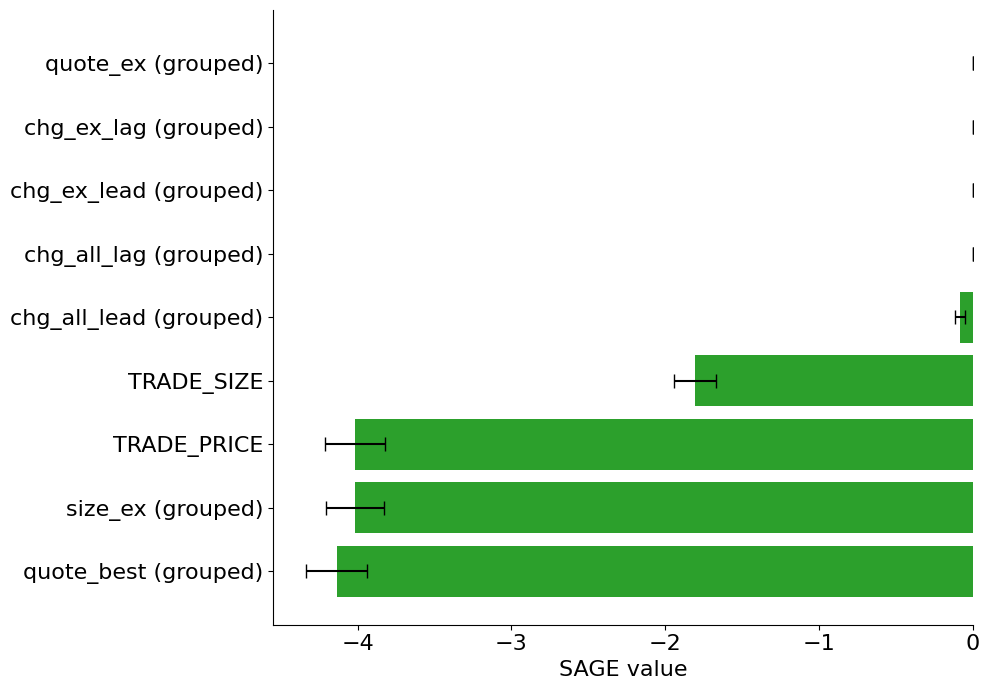

In [8]:
sage_values.plot(group_names, title=None)

### Gradient Boosting 🐈

In [9]:
# load model by identifier from wandb
model = "17malsep_CatBoostClassifier_default.cbm:v7"
model_name = model.split("/")[-1].split(":")[0]

artifact = run.use_artifact(model)
model_dir = artifact.download()

clf = CatBoostClassifier()
clf.load_model(fname=Path(model_dir, model_name))

wandb:   2 of 2 files downloaded.  


In [10]:
imputer = GroupedMarginalImputer(clf, X_test_processed.head(128).values, groups)
estimator = PermutationEstimator(imputer, "cross entropy")
sage_values = estimator(X_test_processed.head(128).values, y_test_processed.head(128).values)

  0%|          | 0/1 [00:00<?, ?it/s]

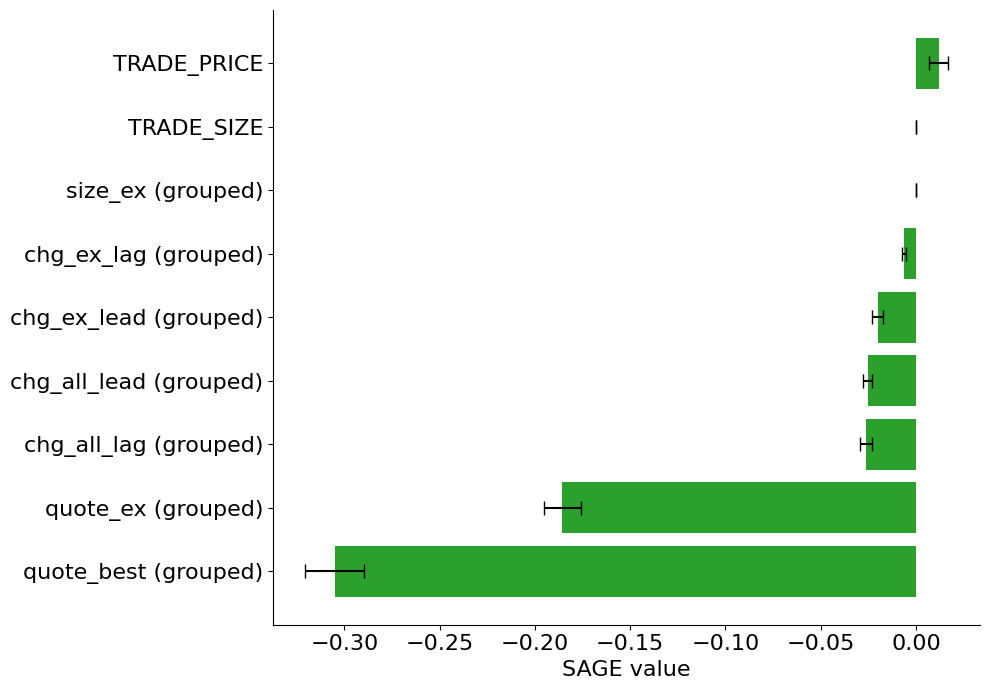

In [11]:
sage_values.plot(group_names, title=None)

### Transformer Classifier 🤖

In [12]:
model = "2rq3hrkw_TransformerClassifier_default.pkl:latest"
model_name = model.split("/")[-1].split(":")[0]

artifact = run.use_artifact(model)
model_dir = artifact.download()
    
with open(Path(model_dir, model_name), 'rb') as f:
    clf = pickle.load(f)

wandb:   1 of 1 files downloaded.  


In [14]:
imputer = GroupedMarginalImputer(clf, X_test_processed.head(1024).values, groups)
estimator = PermutationEstimator(imputer, "cross entropy")
sage_values = estimator(X_test_processed.head(1024).values, y_test_processed.head(1024).values)

  0%|          | 0/1 [00:00<?, ?it/s]

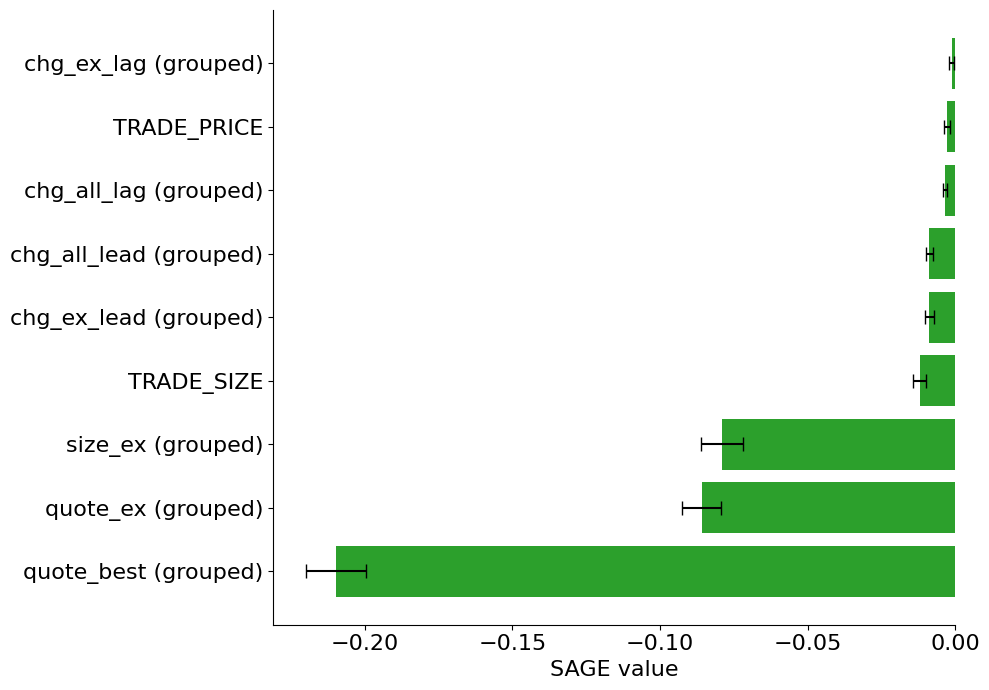

In [15]:
sage_values.plot(group_names, title=None)

In [16]:
model = "i3pvza1q_TransformerClassifier_default.pkl:latest"
model_name = model.split("/")[-1].split(":")[0]

artifact = run.use_artifact(model)
model_dir = artifact.download()
    
with open(Path(model_dir, model_name), 'rb') as f:
    clf = pickle.load(f)

/pfs/data5/home/kit/stud/uloak/thesis/thesis/lib64/python3.9/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
wandb:   1 of 1 files downloaded.  


## Attention Maps for Transformers

We calculate the average attention map from all transformer blocks, as done in the Gorishniy paper (see [here](https://github.com/Yura52/tabular-dl-revisiting-models/issues/2)). This is different from the Borisov paper (see [here](https://github.com/kathrinse/TabSurvey/blob/main/models/basemodel_torch.py)).

In [ ]:
# https://github.com/hila-chefer/Transformer-Explainability/blob/main/BERT_explainability/modules/BERT/ExplanationGenerator.py

import argparse
import numpy as np
import torch
import glob

# compute rollout between attention layers
def compute_rollout_attention(all_layer_matrices, start_layer=0):
    # adding residual consideration- code adapted from https://github.com/samiraabnar/attention_flow
    # https://colab.research.google.com/drive/1nG_6T3mMu9aI7_k_sCpayusONELtJrAP?usp=sharing#scrollTo=gzBbXbEWJZG9
    num_tokens = all_layer_matrices[0].shape[1]
    batch_size = all_layer_matrices[0].shape[0]
    eye = (
        torch.eye(num_tokens)
        .expand(batch_size, num_tokens, num_tokens)
        .to(all_layer_matrices[0].device)
    ) 
    # identity matrix I + E_h(A^l)
    all_layer_matrices = [
        all_layer_matrices[i] + eye for i in range(len(all_layer_matrices))
    ]
    # E_h(A) normalized
    matrices_aug = [
        all_layer_matrices[i] / all_layer_matrices[i].sum(dim=-1, keepdim=True)
        for i in range(len(all_layer_matrices))
    ]
    # batch multiply all together
    joint_attention = matrices_aug[start_layer]
    for i in range(start_layer + 1, len(matrices_aug)):
        joint_attention = matrices_aug[i].bmm(joint_attention)
    return joint_attention


class Generator:
    def __init__(self, model):
        self.model = model
        self.model.eval()

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids, attention_mask)

    def generate_LRP(self, input_ids, attention_mask, index=None, start_layer=11):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        kwargs = {"alpha": 1}

        if index == None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0, index] = 1
        one_hot_vector = one_hot
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        self.model.relprop(torch.tensor(one_hot_vector).to(input_ids.device), **kwargs)

        cams = []
        blocks = self.model.bert.encoder.layer
        for blk in blocks:
            grad = blk.attention.self.get_attn_gradients()
            cam = blk.attention.self.get_attn_cam()
            cam = cam[0].reshape(-1, cam.shape[-1], cam.shape[-1])
            grad = grad[0].reshape(-1, grad.shape[-1], grad.shape[-1])
            cam = grad * cam
            cam = cam.clamp(min=0).mean(dim=0)
            cams.append(cam.unsqueeze(0))
        rollout = compute_rollout_attention(cams, start_layer=start_layer)
        rollout[:, 0, 0] = rollout[:, 0].min()
        return rollout[:, 0]

    def generate_LRP_last_layer(self, input_ids, attention_mask, index=None):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        kwargs = {"alpha": 1}
        if index == None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0, index] = 1
        one_hot_vector = one_hot
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        self.model.relprop(torch.tensor(one_hot_vector).to(input_ids.device), **kwargs)

        cam = self.model.bert.encoder.layer[-1].attention.self.get_attn_cam()[0]
        cam = cam.clamp(min=0).mean(dim=0).unsqueeze(0)
        cam[:, 0, 0] = 0
        return cam[:, 0]

    def generate_full_lrp(self, input_ids, attention_mask, index=None):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        kwargs = {"alpha": 1}

        if index == None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0, index] = 1
        one_hot_vector = one_hot
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        cam = self.model.relprop(
            torch.tensor(one_hot_vector).to(input_ids.device), **kwargs
        )
        cam = cam.sum(dim=2)
        cam[:, 0] = 0
        return cam

    def generate_attn_last_layer(self, input_ids, attention_mask, index=None):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        cam = self.model.bert.encoder.layer[-1].attention.self.get_attn()[0]
        cam = cam.mean(dim=0).unsqueeze(0)
        cam[:, 0, 0] = 0
        return cam[:, 0]

    def generate_rollout(self, input_ids, attention_mask, start_layer=0, index=None):
        self.model.zero_grad()
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        blocks = self.model.bert.encoder.layer
        all_layer_attentions = []
        for blk in blocks:
            attn_heads = blk.attention.self.get_attn()
            avg_heads = (attn_heads.sum(dim=1) / attn_heads.shape[1]).detach()
            all_layer_attentions.append(avg_heads)
        rollout = compute_rollout_attention(
            all_layer_attentions, start_layer=start_layer
        )
        rollout[:, 0, 0] = 0
        return rollout[:, 0]

    # weighted rollout?
    def generate_attn_gradcam(self, input_ids, attention_mask, index=None):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        kwargs = {"alpha": 1}

        if index == None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        # unclear what one_hot use is used for?
        # https://github.com/hila-chefer/Transformer-Explainability/blob/main/BERT_explainability/modules/BERT/BERT.py
        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0, index] = 1
        one_hot_vector = one_hot
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        self.model.relprop(torch.tensor(one_hot_vector).to(input_ids.device), **kwargs)

        cam = self.model.bert.encoder.layer[-1].attention.self.get_attn()
        grad = self.model.bert.encoder.layer[-1].attention.self.get_attn_gradients()

        cam = cam[0].reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad[0].reshape(-1, grad.shape[-1], grad.shape[-1])
        grad = grad.mean(dim=[1, 2], keepdim=True)
        cam = (cam * grad).mean(0).clamp(min=0).unsqueeze(0)
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        cam[:, 0, 0] = 0
        return cam[:, 0]


In [ ]:
import sys
from typing import List

import pandas as pd
import seaborn as sns
import scipy.stats
import torch
from torch import nn

sys.path.append("..")
from otc.models.tabtransformer import TabTransformer


In [ ]:
num_features_cont = 5
num_features_cat = 3
num_unique_cat = tuple([2, 2, 2])
batch_size = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_cat = torch.randint(0, 1, (batch_size, num_features_cat)).to(device)
x_cont = torch.randn(batch_size, num_features_cont).float().to(device)
expected_outputs = torch.randint(0, 1, (batch_size, 1)).float().to(device)

model = TabTransformer(
    cat_cardinalities=num_unique_cat,
    num_continuous=num_features_cont,
    dim_out=1,
    mlp_act=nn.ReLU,
    dim=32,
    depth=2,
    heads=6,
    attn_dropout=0.1,
    ff_dropout=0.1,
    mlp_hidden_mults=(4, 2),
).to(device)


In [ ]:
class SaveAttentionMaps:
    """
    Hook for attention maps.

    Inspired by:
    https://github.com/Yura52/tabular-dl-revisiting-models/issues/2#issuecomment-1068123629
    """

    def __init__(self):
        self.attention_maps: List[torch.Tensor] = []

    def __call__(self, _, __, output):
        print(output[1]["attention_probs"].shape)
        self.attention_maps.append(output[1]["attention_probs"])


In [ ]:
# The following hook will save all attention maps from all attention modules.
hook = SaveAttentionMaps()
for block in model.transformer.blocks:
    block.attention.fn.fn.register_forward_hook(hook)

# Apply the model to all objects.
model.eval()
with torch.inference_mode():
    model(x_cat.clone(), x_cont.clone())

# Collect attention maps
n_objects = len(x_cat)
n_blocks = len(model.transformer.blocks)
n_heads = model.transformer.blocks[0].attention.fn.fn.n_heads

attention_maps = torch.cat(hook.attention_maps)

# Calculate feature importance and ranks.
attention_maps = attention_maps.reshape(
    n_objects * n_blocks * n_heads, num_features_cat, num_features_cat
)
assert attention_maps.shape == (
    n_objects * n_blocks * n_heads,
    num_features_cat,
    num_features_cat,
)

# Calculate feature importance and ranks.
average_attention_map = attention_maps.mean(0)
feature_importance = average_attention_map[-1]

feature_importance = feature_importance.cpu().numpy()
feature_ranks = scipy.stats.rankdata(-feature_importance)
feature_indices_sorted_by_importance = feature_importance.argsort()[::-1]

print(feature_importance)
print(feature_ranks)
print(feature_indices_sorted_by_importance)


In [ ]:
ax = sns.barplot(x=feature_importance, y=["f1", "f2", "f3"])
ax.set(xlim=(0, 1))


In [ ]:
from otc.models.activation import ReGLU
from otc.models.fttransformer import (
    CategoricalFeatureTokenizer,
    CLSToken,
    FeatureTokenizer,
    FTTransformer,
    MultiheadAttention,
    NumericalFeatureTokenizer,
    Transformer,
)

num_features_cont = 5
num_features_cat = 1
cat_cardinalities = [2]
batch_size = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_cat = torch.randint(0, 1, (batch_size, num_features_cat)).to(device)
x_cont = torch.randn(batch_size, num_features_cont).float().to(device)
expected_outputs = torch.randint(0, 1, (batch_size, 1)).float().to(device)

params_feature_tokenizer = {
    "num_continous": num_features_cont,
    "cat_cardinalities": cat_cardinalities,
    "d_token": 96,
}
feature_tokenizer = FeatureTokenizer(**params_feature_tokenizer)
params_transformer = {
    "d_token": 96,
    "n_blocks": 3,
    "attention_n_heads": 8,
    "attention_initialization": "kaiming",
    "ffn_activation": ReGLU,
    "attention_normalization": nn.LayerNorm,
    "ffn_normalization": nn.LayerNorm,
    "ffn_dropout": 0.1,
    "ffn_d_hidden": 96 * 2,
    "attention_dropout": 0.1,
    "residual_dropout": 0.1,
    "prenormalization": True,
    "first_prenormalization": False,
    "last_layer_query_idx": None,
    "n_tokens": None,
    "kv_compression_ratio": None,
    "kv_compression_sharing": None,
    "head_activation": nn.ReLU,
    "head_normalization": nn.LayerNorm,
    "d_out": 1,
}

transformer = Transformer(**params_transformer)

model = FTTransformer(feature_tokenizer, transformer).to(device)


In [ ]:
# Prepare data and model.
n_objects = len(x_cat)  # 12
n_features = num_features_cont + num_features_cat

# The following hook will save all attention maps from all attention modules.
hook = SaveAttentionMaps()
for block in model.transformer.blocks:
    block.attention.register_forward_hook(hook)

# Apply the model to all objects.
model.eval()
with torch.inference_mode():
    model(x_cat, x_cont)

# Collect attention maps
n_blocks = len(model.transformer.blocks)
n_heads = model.transformer.blocks[0].attention.n_heads
n_tokens = n_features + 1
attention_maps = torch.cat(hook.attention_maps)
assert attention_maps.shape == (n_objects * n_blocks * n_heads, n_tokens, n_tokens)

# Calculate feature importance and ranks.
average_attention_map = attention_maps.mean(0)
average_cls_attention_map = average_attention_map[-1]  # consider only the [CLS] token
feature_importance = average_cls_attention_map[:-1]  # drop the [CLS] token importance
assert feature_importance.shape == (n_features,)

feature_importance = feature_importance.cpu().numpy()
feature_ranks = scipy.stats.rankdata(-feature_importance)
feature_indices_sorted_by_importance = feature_importance.argsort()[::-1]

print(feature_importance)
print(feature_ranks)
print(feature_indices_sorted_by_importance)


In [ ]:
ax = sns.barplot(x=feature_importance, y=["f1", "f2", "f3", "f4", "f5", "f6"])
ax.set(xlim=(0, 1))
